Introduction

Electrification of the transportation sector is on the critical path to reducing carbon emissions and mitigating the harmful impacts of climate change. Yet while Tesla remains a hot stock with fashionable products, electrical vehicles remain a niche market. Indeed, adoption has fallen short of where many experts predicted we would be at this stage. 

One of the reasons for this gap - and the subject of the analysis below - is the instability that charging stations introduce to the electrical grid. 

Solving this problem will have both market and policy implications.

In [209]:
import pandas as pd
import seaborn as sns
import json
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, ElasticNet

In [210]:
json_file_path = "/Users/toddhendricks/Downloads/acndata_sessions.json"

with open(json_file_path, 'r') as j:
     data = json.loads(j.read())

In [175]:
df = pd.json_normalize(data['_items'])

Generate a description of the dataset.

In [176]:
charging_slots = df.stationID.nunique()
customers = df.userID.nunique()
sessions = df.sessionID.nunique()
total_mwh_delivered = sum(df.kWhDelivered) / 1000
avg_kwh_delivered = df.kWhDelivered.mean()
"There are {} charging stations on the Caltech campus. The data contains {} unique customers of the stations, with {} unique charging sessions over the course of 2020. The total energy delivered was {} megawatt hours, with the average session delivering {} kilowatt hours.".format(charging_slots, customers, sessions, total_mwh_delivered, avg_kwh_delivered)

'There are 50 charging stations on the Caltech campus. The data contains 203 unique customers of the stations, with 2352 unique charging sessions over the course of 2020. The total energy delivered was 18.709586259402627 megawatt hours, with the average session delivering 7.954756062671184 kilowatt hours.'

In [177]:
df.columns

Index(['_id', 'clusterID', 'connectionTime', 'disconnectTime',
       'doneChargingTime', 'kWhDelivered', 'sessionID', 'siteID', 'spaceID',
       'stationID', 'timezone', 'userID', 'userInputs'],
      dtype='object')

Our target is the duration of a charging session represented in minutes. We will need to convert the relevant columns to datetime objects in order to facilitate the math.

In [178]:
df.connectionTime = pd.to_datetime(df.connectionTime)
df.doneChargingTime = pd.to_datetime(df.doneChargingTime)
# air_quality["datetime"] = pd.to_datetime(air_quality["datetime"])

In [179]:
df.connectionTime = pd.to_datetime(df.connectionTime.dt.strftime('%m/%d/%Y %H:%M')) 
df.doneChargingTime = pd.to_datetime(df.doneChargingTime.dt.strftime('%m/%d/%Y %H:%M'))

In [181]:
df['charging_session_duration'] = df.connectionTime - df.doneChargingTime

In [182]:
df['charging_session_duration']

0      -1 days +22:01:00
1      -1 days +21:37:00
2      -1 days +23:26:00
3      -1 days +23:29:00
4      -1 days +16:02:00
              ...       
2347                 NaT
2348                 NaT
2349                 NaT
2350                 NaT
2351                 NaT
Name: charging_session_duration, Length: 2352, dtype: timedelta64[ns]

In [188]:
df['charging_session_duration_in_hrs'] = (df['charging_session_duration'] / np.timedelta64(1, 'h')) * -1

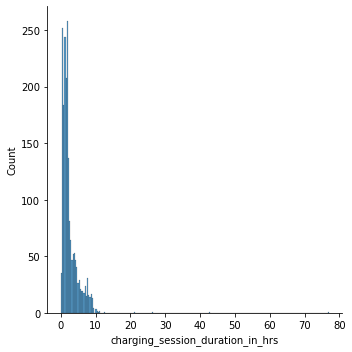

In [190]:
sns.displot(df['charging_session_duration_in_hrs'])

In [193]:
df_less_outliers = df[df['charging_session_duration_in_hrs'] <= 10]

In [194]:
n = 2
data_lost = (len(df_less_outliers) / len(df)) * 100
print("After removing outliers, we have {0:.{1}f} percent of the data we began with.".format(data_lost, n))

After removing outliers, we have 83.72 percent of the data we began with.


Our target is right-skewed which makes intuitive sense. Most of the sessions are short, but there are a few that are very long. From a modeling standpoint, we will consider applying a power transformation at the engineering stage.

<AxesSubplot:xlabel='kWhDelivered', ylabel='charging_session_duration_in_hrs'>

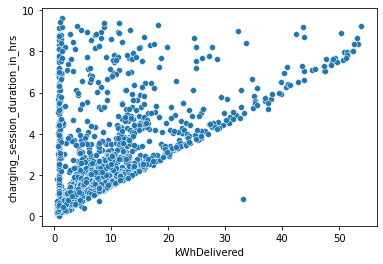

In [195]:
sns.scatterplot(data=df_less_outliers, x='kWhDelivered', y='charging_session_duration_in_hrs')

The scatterplot reveals an interesting property of the data: there is a limit to how fast a vehicle can be charged - but there's no upper bound. Physics would explain the lower boundary. We do not yet know what covariate(s) explain the variance above the hard lower bound.
The vector of zeros on the X axis is also interesting. There are a considerable number of sessions where the vehicle is supposedly charging - but it is not registering kWh delivered. 

In [196]:
by_parking_slot = df_less_outliers.groupby(by='stationID').mean()

In [197]:
x = by_parking_slot['kWhDelivered']
y = by_parking_slot['charging_session_duration_in_hrs']

<AxesSubplot:xlabel='kWhDelivered', ylabel='charging_session_duration_in_hrs'>

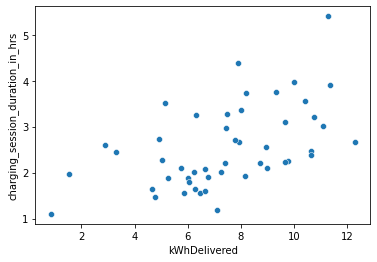

In [198]:
sns.scatterplot(x=x,y=y)

In [199]:
X,y = df_less_outliers['kWhDelivered'], df_less_outliers['charging_session_duration_in_hrs']
X = X.values.reshape(-1,1)

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [201]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [202]:
lr.score(X_test, y_test)

0.2698065983907535

We now have a baseline model. The task before us is to reduce the bias of our model by introducing complexity. 

In [206]:
y_pred = lr.predict(X_test)
y_true = y_test

In [211]:
mean_absolute_error(y_pred,y_test)

1.2184118681127292

We can intepret our current state as "Our model can predict to the hour - give or take an hour." 